A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

# Data Preperation  

In [17]:
from io import open 
import glob
import os, unicodedata, string

findFiles = lambda path: glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        # NFD = normal form D
        c for c in unicodedata.normalize("NFD", s)
        # Mn = 	Mark, Nonspacing = marks like ' and accent marks 
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names-data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


We can now map names to languages

In [18]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Names to Tensors

In [19]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

assert 26 + 26 + 5 == n_letters, "The number of letters is wrong"

print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


## Creating a Network

In [20]:
import torch.nn as nn
import torch.nn.functional as F 

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [21]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [22]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7249, -2.9799, -2.7976, -2.8989, -2.9480, -2.9960, -2.7669, -2.9255,
         -2.8487, -2.9166, -2.7978, -2.9207, -2.8557, -3.1461, -2.7784, -2.9307,
         -2.9132, -2.9665]], grad_fn=<LogSoftmaxBackward0>)


## Training

In [25]:
def categoryFromOutput(output):
    # using top k sampling 
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 0)


We will also want a quick way to get a training example (a name and its language):

In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Guerrero
category = Japanese / line = Yuhara
category = Italian / line = Tamboia
category = Irish / line = Seighin
category = German / line = Schumacher
category = Korean / line = Youn
category = French / line = Perrault
category = Russian / line = Abrakhimov
category = Italian / line = Sordi
category = Greek / line = Vourlis


The last layer of the RNN is LogSoftmax is the most appropriate loss function will be `nn.NLLLoss()`

At each loop training will:
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
    - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [27]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        # calls forward by default 
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Training on samples

In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 3.1771 Siekert / Spanish ✗ (German)
10000 10% (0m 9s) 3.1394 Perina / Italian ✗ (Czech)
15000 15% (0m 14s) 0.7763 Stawski / Polish ✓
20000 20% (0m 19s) 3.5939 Mcnab / Czech ✗ (Irish)
25000 25% (0m 24s) 1.9354 Fakhoury / Irish ✗ (Arabic)
30000 30% (0m 29s) 0.1390 Papoutsis / Greek ✓
35000 35% (0m 34s) 1.5262 Abbott / German ✗ (English)
40000 40% (0m 38s) 2.3622 Taylor / Arabic ✗ (Scottish)
45000 45% (0m 43s) 0.0061 Shibasaki / Japanese ✓
50000 50% (0m 48s) 0.0837 Pakulski / Polish ✓
55000 55% (0m 53s) 3.4789 Miyamae / Greek ✗ (Japanese)
60000 60% (0m 58s) 0.3582 Rebka / Czech ✓
65000 65% (1m 3s) 0.2575 Guo / Chinese ✓
70000 70% (1m 7s) 0.5220 Watoga / Japanese ✓
75000 75% (1m 12s) 0.0883 Durant / French ✓
80000 80% (1m 17s) 0.2086 Szewc / Polish ✓
85000 85% (1m 22s) 0.4122 Docherty / Scottish ✓
90000 90% (1m 27s) 0.0688 Shammas / Arabic ✓
95000 95% (1m 32s) 0.0999 Hatakeyama / Japanese ✓
100000 100% (1m 36s) 0.7127 Otsu / Japanese ✓


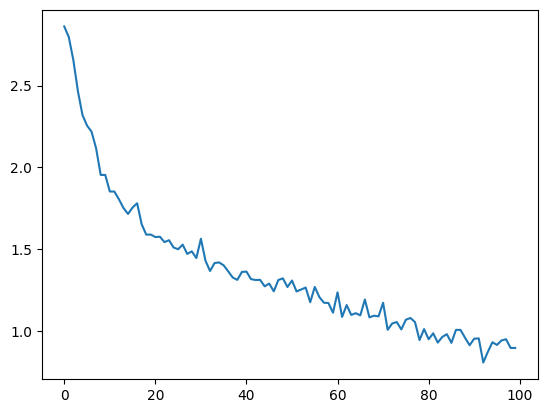

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluation 

To see how well the network performs on different categories, we create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). 

To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

C:\Users\richa\AppData\Local\Temp\ipykernel_8092\3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\richa\AppData\Local\Temp\ipykernel_8092\3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


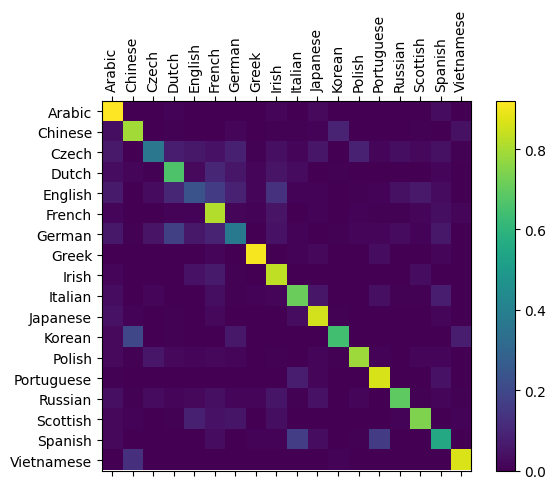

In [30]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### User Input 

In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [32]:
predict("Coricova")


> Coricova
(-0.17) Czech
(-3.03) Russian
(-3.38) Spanish


**Using Files**
- data.py (loads files)
- model.py (defines the RNN)
- train.py (runs training)
- predict.py (runs predict() with command line arguments)

**Extention**
- Get better results with a bigger and/or better shaped network
- Add more linear layers
- Try the nn.LSTM and nn.GRU layers
- Combine multiple of these RNNs as a higher level network

## References
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
- https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification